# Dataset Overview

In [ ]:
import numpy as np
import pandas as pd
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pd.set_option('max_colwidth' , None)

df = pd.read_csv('Developer Kaki _ Developer Salary Survey 2021 Results - Form responses 1.csv')
df.head(3)

,Timestamp,Gender,Age,Nationality,Current Country of Residence,Current State of Residence,Current City of Residence,Highest Level of Education,Name of Highest Degree Obtained,Name of School or University,Is your degree tech related?,Did you go through a bootcamp to learn technical skills?,"Professional Certification (Eg. CCNA, CEH, GCP Cloud Associate)",Name of Bootcamp Course,Name of Professional Certification(s),Job Title,What is your currency code?,What is your current monthly base salary?,What is your current bonus compensation per year?,What is your current equity (stock) compensation per year?,How many days of annual leave are you entitled to?,Company Benefits,What technologies do you use for work on a regular basis?,Company Location,Company Industry,What is the size of your company?,What is the size of your tech team?,What's the name of your company? [Optional],Satisfaction Level of Current Job,Years of Experience,Number of past employments/jobs (excluding the current one),What was your starting monthly salary?,Indicate in 3-character currency code for starting monthly salary
0,26/07/2021 20:04:28,Male,41,Malaysian,Singapore,NaN,NaN,Masters Degree,Masters of Computer Science,CMU,Yes,No,No,NaN,NaN,CTO,SGD,2000,0,"SGD 1,000,000",18,Learning and Development,The Internet,Singapore,Robotics,11-50 employees,2 - 10 people,NaN,10,20,5,1000.0,NaN
1,26/07/2021 20:04:50,Male,28,Malaysian,Malaysia,Negeri Sembilan,Tampin,"Pre-university (STPM, A-Levels, Matriculation, CPU, IB, etc.)",NaN,Taruc,NaN,No,No,NaN,NaN,Front end team lead,MYR,4500,NaN,NaN,18,"Vacation/Personal Days, Remote Work","Angular, NestJS, Laravel, WordPress, NextJS","Johor, Malaysia","Transport, Logistics",1-10 employees,2 - 10 people,NaN,8,5,6,4500.0,NaN
2,26/07/2021 20:05:11,Male,23,Malaysian,Malaysia,Kuala Lumpur,Kuala Lumpur,Undergraduate Degree,Bachelor of Computer Science,Monash University,Yes,No,No,NaN,NaN,Associate Developer,MYR,5000,0,0,16,"Health Insurance, Life Insurance, Paternity Leave, Vacation/Personal Days, Gym/Wellness Reimbursement, Company Laptop",Configura Magic,"Kuala Lumpur, Malaysia",Space planning,201-1000 employees,51 - 200 people,Configura,7,0,0,5000.0,NaN


In [ ]:
df.shape

(536, 33)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 33 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Timestamp                                                          536 non-null    object 
 1   Gender                                                             536 non-null    object 
 2   Age                                                                536 non-null    int64  
 3   Nationality                                                        535 non-null    object 
 4   Current Country of Residence                                       536 non-null    object 
 5   Current State of Residence                                         499 non-null    object 
 6   Current City of Residence                                          493 non-null    object 
 7   Highest Level of Education

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,536.0,27.712687,4.413182,15.00,24.0,27.0,30.0,44.0
What is your current monthly base salary?,536.0,25108.158582,397562.281905,1.00,3900.0,5500.0,8000.0,9200000.0
How many days of annual leave are you entitled to?,536.0,105.854478,1712.350017,-1.00,14.0,14.0,18.0,38400.0
Satisfaction Level of Current Job,536.0,7.119403,1.911284,1.00,6.0,7.0,8.0,10.0
What was your starting monthly salary?,536.0,3752.566399,10021.019761,0.01,2500.0,3000.0,3500.0,230000.0


A simple helper function is created to check which columns shall be dropped. Columns which have a threshold of 60% of more null values shall be dropped from the dataset.

In [ ]:
def null_percentage():
    col = []
    perc = []
    null_col = [col for col in df.columns if df[col].isnull().any() == True]
    for i in null_col:
        null_perc = (df[i].isnull().sum() / len(df)) * 100
        col.append(i)
        perc.append(null_perc)
        
    return pd.DataFrame(data=zip(col,perc) ,columns=['Columns','Null Percentage'])

In [ ]:
null_percentage()

,Columns,Null Percentage
0,Nationality,0.186567
1,Current State of Residence,6.902985
2,Current City of Residence,8.022388
3,Name of Highest Degree Obtained,9.141791
4,Name of School or University,11.007463
5,Is your degree tech related?,3.358209
6,Name of Bootcamp Course,89.925373
7,Name of Professional Certification(s),83.768657
8,What is your current bonus compensation per year?,9.701493
9,What is your current equity (stock) compensation per year?,22.574627


# Data Preprocessing & Cleaning

1. Data columns renaming

In [ ]:
df.rename(columns={
    'What was your starting monthly salary?':'Starting Monthly Salary',
    'Number of past employments/jobs (excluding the current one)':'Past Employments',
    'What is the size of your tech team?':'Tech Team Size',
    'What is the size of your company?':'Company Size',
    'What technologies do you use for work on a regular basis?':'Technologies Used',
    'Is your degree tech related?':'Degree in Tech',
    'How many days of annual leave are you entitled to?':'Annual Leave Entitled',
    'What is your current equity (stock) compensation per year?':'Stock Compensation (Year)',
    'What is your current bonus compensation per year?':'Bonus Compensation (Year)',
    'What is your currency code?': 'Currency',
    'What is your current monthly base salary?':'Monthly Base Salary',
    'Did you go through a bootcamp to learn technical skills?':'Attended Bootcamp'
    }, inplace =True)

df.columns

Index(['Timestamp', 'Gender', 'Age', 'Nationality',
       'Current Country of Residence', 'Current State of Residence',
       'Current City of Residence', 'Highest Level of Education',
       'Name of Highest Degree Obtained', 'Name of School or University',
       'Degree in Tech', 'Attended Bootcamp',
       'Professional Certification (Eg. CCNA, CEH, GCP Cloud Associate)',
       'Name of Bootcamp Course ', 'Name of Professional Certification(s)',
       'Job Title', 'Currency', 'Monthly Base Salary',
       'Bonus Compensation (Year)', 'Stock Compensation (Year)',
       'Annual Leave Entitled', 'Company Benefits', 'Technologies Used',
       'Company Location', 'Company Industry', 'Company Size',
       'What is the size of your tech team? ',
       'What's the name of your company? [Optional]',
       'Satisfaction Level of Current Job', 'Years of Experience',
       'Past Employments', 'Starting Monthly Salary',
       'Indicate in 3-character currency code for starting monthl

In [ ]:
def clean_company_tech_size(x):
    x = x.replace(',','').replace(r'employees' , ' ')
    return x 


df['Company Size'] = df['Company Size'].apply(clean_company_tech_size)
#df['Tech Team Size'] = df['Tech Team Size'].apply(clean_company_tech_size)

2. Handling missing Data 

**i. General cleaning of numerical and categorical feature**

Further inspection of the columns showed that individual columns may or may not have mixed data types. Two functions have been created to remove mixed minority data type within each column and depending on whether feature is numerical or categorical performs cleaning:

a. Numerical features: Fill null values with mean of data distribution across that feature

b. Categorical features: Fill null values with the most common recurring (mode) value across that feature


In [ ]:
def clean_categorical(col):
  df[col] = df[col].fillna(df[col].value_counts().idxmax())
  return df[col]  
  

def clean_numerical(col):
  df[col] = pd.to_numeric(df[col] , errors = 'coerce')
  df[col] = df[col].fillna(df[col].mean())

  return df[col]

3. Text Preprocessing

Text cleaning was done on particular features 'Company Benefits' and 'Technologies Used'. Imputation of these two features have been done previously thus focusing on the processing steps inclusive of:

1. Lowering each word within each rows
2. Filtering out general stopwords
3. Remove unnecessary punctuations
4. Lemmatizing the columns

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import re 
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def clean_skills(x):
  clean_text = []
  final_text = []
  text = re.sub(',','',str(x).lower())
  clean_text = [lemmatizer.lemmatize(word , pos='n') for word in word_tokenize(text)]
  final_text = [skill for skill in clean_text if skill not in stopwords]

  return " ".join(final_text)

In [ ]:
def clean_benefits(x):
  clean_text = []
  final_text = []
  text = re.sub(",",'',x)
  text = re.sub

In [ ]:
temp['Technologies Used'] = temp['Technologies Used'].apply(clean_skills)

Exploratory Data Analysis

Data visualization was done after cleaning up null values. By using boxplots, the data distribution of features can be observed and most importantly to look for outliers to decide whether to be processed or remained as it is.

In [ ]:
def create_boxplot(col):
  fig, ax = plt.subplots(1,1, figsize=(8,8))
  
  i = 0
  #for col in columns:
  sns.boxplot(x = df[col] , ax=ax[i])
  plt.set_title('Boxplot of ' + col)
  plt.xlabel(col)
  #i += 1
  plt.show()
  
  plt.tight_layout()

In [ ]:
def plot_numerical()

In [ ]:
def plot_categorical()


In [ ]:
sns.heatmap(df.corr, annot=True)

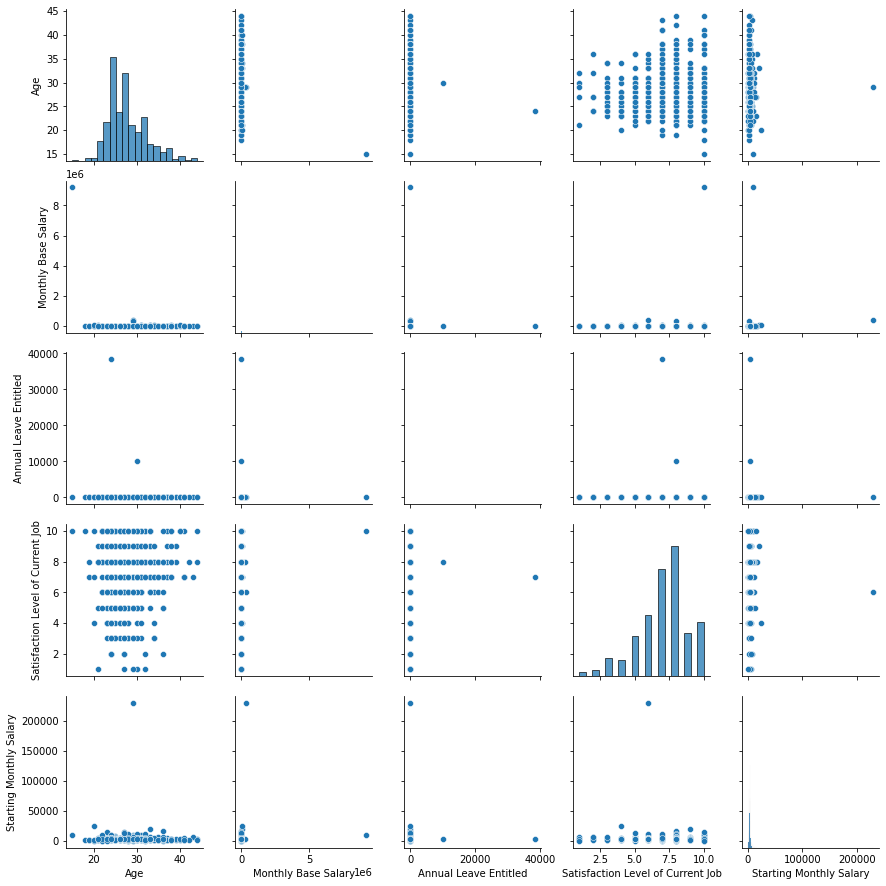

In [ ]:
sns.pairplot(df)